# Trabalho 2 de IA
## Aluno: Gabriel Ferrari Cipriano

### get_score_stts(scores):
####    Entrada: lista de scores
####    Retorno: Dicionário de informações (statuses)
    {Média, desvio padrão, lim inferior, lim superior}

In [2]:
import warnings
import numpy as np
from scipy.stats import norm

# retorna um dict contendo media, variancia e limites inf & sup de uma lista de scores
def get_score_stts(scores):
    r = {}
    r["mean"], r["std"] = scores.mean(), scores.std()

    scale = r["std"]/np.sqrt(len(scores))
    with warnings.catch_warnings():
        if r["std"] == 0.0:
            warnings.simplefilter('ignore') #Ignora warning que são causados quando a variância = 0
        r["inf"], r["sup"] = np.nan_to_num(norm.interval(0.95, loc=r["mean"], scale=scale), nan=r["mean"])
        
    return r


#### RANDOM SEED

In [3]:
rand_state = 36851234

## Implementação do genetic Algorithm para o Kcentroides

### Classe clustering para lidar com um problema de clusterização
    Nescessária para a implementação do Genetic Algorithm

In [4]:
import random as rand
import numpy as np
from scipy.spatial.distance import cdist

# Utils
def evaluate_dists_state(min_dists):
    '''
        Return: SSE baseado na array de distancias
    '''
    return np.sum(min_dists)

def get_diff_obs_state(current_label, k):
    '''
        Retorna uma label diferente da label atual entre as k disponiveis
    '''
    new_label = rand.randrange(k)
    if new_label == current_label: new_label = (new_label + 1) % k
    return new_label


'''
Modulo da classe do problema de clustering.
    tipo de estrutura de dados:
        Numpy 2-dimensional arrays
'''
class Clustering:
    '''Lida com a instãncia de um problema de clusterização.
    '''
    def __init__(self, data):
        '''valores do problema:
                data: ndarray size M x N
                    Cada linha da array é uma observação.
                    As colunas são os atributos de cada observação
                num_obs: int
                    Número de observações no dataset
                num_feat: int
                    numero de features (atributos) no dataset
        '''
        self.data = data
        self.num_obs = len(data)
        self.num_feat = len(data[0])

    def generate_initial_centroids(self, k):
        '''
            Seleciona aleatoriamente K linhas para serem os centroides
        '''
        points = np.random.choice(self.num_obs, size=k, replace=False)
        return self.data[points].copy()

    def get_centroid(self):
        return (self.data.sum(axis=0) / self.num_obs)


    def update_centroids(self, labels, k):
        """ Parameters:
                labels : int ndarray
                    array of the labels of the observations.
                k : int
                    The number of centroids (codes).
            Returns:
                centroids: k x n ndarray
                new centroids matrix
                has_members : ndarray
                    A boolean array indicating which clusters have members.
        """
        centroids = np.zeros((k, self.num_feat), dtype=self.data.dtype)

        # sum of the numbers of obs in each cluster
        obs_count = np.zeros(k, np.int)

        for i in range(self.num_obs):
            label = labels[i]
            obs_count[label] += 1
            centroids[label] += self.data[i]

        for i in range(k):
            cluster_size = obs_count[i]

            if cluster_size > 0:
                # Calculate the centroid of each cluster
                centroids[i] = centroids[i] / cluster_size

        # Return a boolean array indicating which clusters have members
        return centroids, obs_count > 0

    def update_centroids_safe(self, centroids, labels, k):
        """ Atualiza o estado da lista de centroides com base nas labels
            Difere da função update_centroids por corrigir internamente
            problemas de cluster sem membros
        """
        new_centroids, has_members = self.update_centroids(labels, k)
        # Caso algum centroide novo não possua membros, atribui a posicao anterior
        if not has_members.all():
            # Setting to previous centroid position
            new_centroids[~has_members] = centroids[~has_members]
        return new_centroids

    def assign_clusters(self, centroids):
        ''' Parametros:
                centroids: ndarray size k x N
                    Cada linha é um centroide
            Retornos:
                labels: ndarray size M
                    Uma array contendo o index do cluster atribuido a cada observacao
                min_dists: ndarray size M
                    Array contendo a distancia da i-ésima observação até o centroide mais proximo
        '''
        dists = cdist(self.data, centroids, 'sqeuclidean')
        labels = dists.argmin(axis=1)
        min_dists = dists[np.arange(len(labels)), labels]
        return labels, min_dists

    # GENTIC ALGORITHN
    def evaluate(self, state):
        """Retorna o sse de um centroide (state)"""
        min_dists = self.assign_clusters(state)[1]
        return evaluate_dists_state(min_dists)

    def gerar_populacao(self, populacao, t_pop, k):
        """Preenche uma população a partir do primeiro individuo da população dada
        """
        state = populacao[0]
        labels = self.assign_clusters(state)[0]

        while len(populacao) < t_pop:
            new_labels = labels.copy()
            rand_obs = rand.randrange(0, self.num_obs)

            new_labels[rand_obs] = get_diff_obs_state(labels[rand_obs], k)
            new_state, has_members = self.update_centroids(new_labels,k)

            if has_members.all():
                populacao.append(new_state)

    def selecao(self, states):
        """ função de selecao por roleta (mantendo um unico sobrevivente na população)
                1º: calcula as probabilidades de cada um sobreviver
                2º: calcula a faixa de sobrevivência
                3º: Roda a roleta
        """
        total = sum(list(map(self.evaluate, states)))
        percents = list(map(lambda s: (s, self.evaluate(s)/total),states))

        prob_ranges = list()
        low_bound = 0
        for s in percents:
            prob_ranges.append((s[0], low_bound, low_bound + s[1]))
            low_bound += s[1]

        n = rand.random()
        # n = rand.uniform(0,1)
        for prob in prob_ranges:
            if n >= prob[1] and n <= prob[2]:
                states.clear()
                states.append(prob[0])

    def mutacao(self, state):
        labels = self.assign_clusters(state)[0]
        k = len(state)

        # define aleatoriamente quantas mutacoes acontecerao nas labels (até 10)
        for _ in range(rand.randint(1,10)):
            rand_obs = rand.randrange(0, self.num_obs)
            labels[rand_obs] = get_diff_obs_state(labels[rand_obs], k)

        new_state = self.update_centroids_safe(state, labels, k)

        return new_state

    def melhor_da_geracao(self, states):
        num_pop = len(states)

        melhor = states[0].copy()
        melhor_sse = self.evaluate(states[0])

        for i in range(1, num_pop):
            sse = self.evaluate(states[i])
            if sse < melhor_sse:
                melhor = states[i].copy()
                melhor_sse = sse

        return melhor, melhor_sse

## Genetic Algorithm

In [5]:
""" Metodo Algoritmo Genético
        Hiperparametros : 
            max_iter : número máximo de iterações (critério de parada)
            t_pop : tamanho da população
            taxa_cross : chance de ocorrer crossover
            taxa_mutacao : chance de ocorrer mutação

        Tipo : Baseada em Soluções Completas -> Busca Populacional 
"""
import time
import random as rand
import numpy as np

def crossover(state1, state2):
    num_feat = len(state1)
    # Quantidade aleatoria de crossovers
    qtd = rand.randint(0, num_feat)

    for _ in range(qtd):
        gene = rand.randrange(num_feat)
        aux = state1[gene]
        state1[gene] = state2[gene]
        state2[gene] = aux


def genetic(problem: Clustering, k, t_pop, taxa_cross, taxa_mutacao, t = 2., max_sem_melhora = 10, max_iter = 5000):
    """ Parametros : 
            problem : uma instancia do problema de clustering
            k : quantidade de centroides
            t_pop : tamanho da população
            taxa_cross : chance de ocorrer crossover
            taxa_mutacao : chance de ocorrer mutação
            max_sem_melhora : quantidade maxima de iteracoes sem melhora (critério de parada)
            max_iter : número máximo de iterações (critério de parada)
            t : tempo
    """
    start = time.process_time()
    end = 0

    if k == 1:
        return [problem.get_centroid()], time.process_time()-start, 1

    melhor = problem.generate_initial_centroids(k)
    populacao = [melhor]

    melhor_sse = np.inf
    qtd_geracoes_sem_melhora = 0

    i = 0

    while i < max_iter and qtd_geracoes_sem_melhora < max_sem_melhora and end-start < t:
        # Seleciona um estado com potencial e gera a população
        problem.selecao(populacao)
        problem.gerar_populacao(populacao, t_pop, k)

        # Realiza um numero aleatorio de crossovers e mutacoes, 
        # entre metade do tamanho e o tamanho da populacao
        for _ in range(1, rand.randrange(t_pop//2,t_pop)):
            # if end-start < t:
            #     break
            # Crossover
            if taxa_cross >= rand.random():
                x = rand.randrange(len(populacao))
                y = rand.randrange(len(populacao))
                if x == y:
                    y = y-1
                crossover(populacao[x], populacao[y])
            # Mutacao
            if taxa_mutacao >= rand.random():
                x = rand.randrange(len(populacao))
                populacao[x] = problem.mutacao(populacao[x])
                
            end = time.process_time()

        melhor_da_geracao, melhor_sse_geracao = problem.melhor_da_geracao(populacao)

        if melhor_sse_geracao < melhor_sse:
            melhor = melhor_da_geracao
            melhor_sse = melhor_sse_geracao
            qtd_geracoes_sem_melhora = 0
        else:
            qtd_geracoes_sem_melhora += 1

        i += 1
        end = time.process_time()

    return melhor, end-start, i

### KGAcentroides

In [6]:
import random as rand
# Encapsulamento do genetic Algorithm
def kga(data, k, random_state=None):
    problem = Clustering(data)
    centroids, _, _ =  genetic(problem, k, t_pop=10, taxa_cross=0.95, taxa_mutacao=0.2)
    return centroids

In [7]:
from sklearn.cluster import KMeans

# Encapsulamento do kmeans
def kmeans(data, k, random_state=None):
    km = KMeans(n_clusters=k, random_state=random_state)
    km.fit(data)
    return km.cluster_centers_

In [8]:
'''
classe do classificador KCentroides.
    Inicialização:
        O KCentroides precisa receber um K e um método de agrupamento como parâmetros.
        O método de agrupamente precisa ser no seguinte padrão:
            Parâmetros: data, k e random_seed
            Retorno: A lista de K centroides
'''

import numpy as np
from scipy.spatial.distance import cdist

from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y



class Kcentroides(BaseEstimator):
    def __init__(self, method=None, k=5, random_state=None):
        super().__init__()
        self.k = k
        self.method = method
        self.random_state = random_state
    
    def fit(self,x_train,y_train):
        x_train,y_train = check_X_y(x_train,y_train)
        clss_names = np.unique(y_train)
        mapp = { k: i for i, k in  enumerate(clss_names)}
        

        # Faz uma lista de classes, mapeando as classes em indices
        x_classes = [[] for i in range(len(clss_names))]
        for observation, clss in zip(x_train, y_train):
            x_classes[mapp[clss]].append(observation)
        
        
        # gera os k centroids de cada classe
        c_classes = [[] for i in range(len(clss_names))]
        for clss, x_clss in enumerate(x_classes):
            c_classes[clss] = self.method(np.array(x_clss), self.k, self.random_state)

        self.__c_classes = np.asarray(c_classes)
        self.__clss_names = clss_names

        return self

    def predict(self,x_test):
        dist_array = [ np.min(cdist(x_test, c_clss, 'sqeuclidean'),axis=1) for c_clss in self.__c_classes]
        return self.__clss_names[np.argmin(dist_array, axis=0)]

In [9]:
import pandas as pd
import random as rand

from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y

def run_roulettes(roulettes, random_state = None):
    rand.seed(random_state)
    results = []
    for attr in roulettes:
        chosen = rand.random()
        for i, odd in enumerate(attr):
            if chosen <= odd:
                results.append(i)
                break
    return results

class OneRProbabilistico(BaseEstimator):
    def __init__(self, random_state=None):
        super().__init__()
        self.random_state = random_state

    def fit(self, x_train, y_train):
        x_train, y_train = check_X_y(x_train, y_train)

        # Contingency Table for each attribute in x
        contin_table = [pd.crosstab(attribute, y_train) for attribute in x_train.T ]
        # index and table of the best Attribute for differentiation
        self.i_best_attr = np.argmax([table.max(axis=1).sum() for table in contin_table])
        best_attr = contin_table[self.i_best_attr]
        # class distribution
        self.class_dist = best_attr.div(best_attr.sum(axis=1), axis=0)

        return self

    def predict(self, X):
        attr_values = X.T[self.i_best_attr]
        attr_chances = self.class_dist.loc[attr_values].values

        # Build Roulette list: [0.1, 0.5, 0.4] => [0.1, 0.6, 1.0]
        roulettes = attr_chances.copy()
        for attr in roulettes:
            for a, b, i in zip(attr, attr[1:], range(1,len(attr))): attr[i] = a + b
        
        # Run roulette
        predicted_results = run_roulettes(roulettes, self.random_state)

        return predicted_results

### Função da Etapa 1
    Entrada: Dataset, método, needs_discretizer (bool)
    Retorno: Dicionário { scores, status, tempo }

In [10]:
import time
import warnings

# from sklearn.model_selection import cross_val_predict #Para heatmap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

def phase_one(dataset, method, needs_discretizer=False, random_state=None):
    start = time.process_time()
    x, y = dataset.data, dataset.target

    rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)

    pipe_list = [('transformer', StandardScaler()), ('estimator', method)]
    if needs_discretizer: 
        discretizer = KBinsDiscretizer(n_bins=2*len(np.unique(y)), encode = 'ordinal', strategy = 'kmeans')
        pipe_list.insert(1, ('discretizer', discretizer))

    pipeline = Pipeline(pipe_list)

    with warnings.catch_warnings():
        if needs_discretizer: #Ignora warnings causados pelo número de bins
            warnings.simplefilter('ignore')
        scores = cross_val_score(pipeline, x, y, cv=rkf, scoring="accuracy")
        
    status = get_score_stts(scores)

    return {"scores": scores, "status": status, "time": time.process_time()-start}


#### Exemplo Fase 1:

In [11]:
from sklearn import datasets
OneR = OneRProbabilistico(random_state=rand_state)
phase_one(datasets.load_iris(), OneR, needs_discretizer=True, random_state=rand_state)

{'scores': array([1.        , 0.8       , 1.        , 0.86666667, 0.86666667,
        0.86666667, 1.        , 0.93333333, 0.86666667, 0.8       ,
        1.        , 0.93333333, 0.8       , 0.86666667, 0.8       ,
        1.        , 0.93333333, 0.93333333, 0.93333333, 0.93333333,
        0.93333333, 1.        , 0.86666667, 0.8       , 0.73333333,
        1.        , 0.93333333, 0.93333333, 1.        , 0.93333333]),
 'status': {'mean': 0.908888888888889,
  'std': 0.07597920443235004,
  'inf': 0.8817005793659591,
  'sup': 0.9360771984118188},
 'time': 1.711411}

### Função da etapa 2

In [12]:
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler

def phase_two(dataset, method, grid, random_state=None):
    start = time.process_time()
    x, y = dataset.data, dataset.target

    pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', method)])

    inner = StratifiedKFold(n_splits=4,random_state=random_state, shuffle=True)
    inner_gs = GridSearchCV(estimator=pipeline, param_grid = grid, scoring='accuracy', cv = inner)
        
    outter = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)

    scores = cross_val_score(inner_gs, x, y, scoring='accuracy', cv = outter)
    status = get_score_stts(scores)

    return {"scores": scores, "status": status, "time": time.process_time()-start}

#### Exemplo etapa 2:

In [13]:
from sklearn import datasets
kmeansC = Kcentroides(method=kmeans, random_state=rand_state)
grid = {'estimator__k': [1,3,5]}
phase_two(datasets.load_iris(), kmeansC, grid, random_state=rand_state)


{'scores': array([0.93333333, 0.93333333, 0.86666667, 1.        , 0.93333333,
        0.93333333, 1.        , 0.93333333, 0.93333333, 1.        ,
        1.        , 1.        , 0.93333333, 1.        , 0.8       ,
        0.93333333, 0.93333333, 0.93333333, 0.93333333, 1.        ,
        1.        , 1.        , 1.        , 0.93333333, 0.86666667,
        0.93333333, 0.93333333, 0.93333333, 1.        , 1.        ]),
 'status': {'mean': 0.9511111111111111,
  'std': 0.04848316495393651,
  'inf': 0.93376195215022,
  'sup': 0.9684602700720023},
 'time': 17.790089000000002}

### INICIALIZANDO CLASSIFICADORES E DATASETS

In [14]:
from sklearn import datasets

# Classificadores
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

rand_state = 36851234

datasets_ = {
    'Iris': datasets.load_iris(),
    'Digits': datasets.load_digits(),
    'Wine': datasets.load_wine(),
    'Breast Cancer': datasets.load_breast_cancer()
}

classifs = {
    "call": {
        "ZeroR": DummyClassifier(strategy="most_frequent", random_state=rand_state),
        "Aleatorio": DummyClassifier(strategy="uniform", random_state=rand_state),
        "Estratificado": DummyClassifier(strategy="stratified", random_state=rand_state),
        "OneR Probab": OneRProbabilistico(random_state=rand_state), 
        "Naive Bayes": GaussianNB(),
        "KMeans": Kcentroides(method=kmeans, random_state=rand_state),
        "KGA": Kcentroides(method=kga, random_state=rand_state),
        "KNN": KNeighborsClassifier(weights='uniform'), 
        "DistKNN": KNeighborsClassifier(weights='distance'),
        "Árvore Desc": DecisionTreeClassifier(random_state=rand_state),
        "Floresta": RandomForestClassifier(random_state=rand_state)
    },
    "p_grid": {
        "KMeans": {'estimator__k': [1,3,5,7]},
        "KGA": {'estimator__k': [1,3,5,7]},
        "KNN": {'estimator__n_neighbors': [1,3,5,7]}, 
        "DistKNN": {'estimator__n_neighbors': [1,3,5,7]},
        "Árvore Desc": {'estimator__max_depth': [None, 3, 5,10]},
        "Floresta": {'estimator__n_estimators': [10,20,50,100]}
    },
    "needs_discrete": ["OneR Probab"]
}


### Inicializar dicionario que guardará os resultados

In [15]:
# Initializing results dict
results = {k: dict(dict.fromkeys(classifs["call"])) for k in  datasets_}

# RODANDO TREINO/TESTE DE AMBAS ETAPAS

In [16]:
# Processando
for dataset, ds_data in datasets_.items():
    for method, call in classifs["call"].items():
        if method not in classifs["p_grid"]:
            results[dataset][method] = phase_one(ds_data, call, method in classifs["needs_discrete"], rand_state)
        else:
            results[dataset][method] = phase_two(ds_data, call, classifs["p_grid"][method], rand_state)
        print(dataset, method, results[dataset][method]["status"], round(results[dataset][method]["time"], 2))

Iris ZeroR {'mean': 0.3333333333333334, 'std': 1.1102230246251565e-16, 'inf': 0.33333333333333337, 'sup': 0.3333333333333335} 0.06
Iris Aleatorio {'mean': 0.26666666666666666, 'std': 0.0, 'inf': 0.26666666666666666, 'sup': 0.26666666666666666} 0.06
Iris Estratificado {'mean': 0.4666666666666667, 'std': 0.0, 'inf': 0.4666666666666667, 'sup': 0.4666666666666667} 0.06
Iris OneR Probab {'mean': 0.908888888888889, 'std': 0.07597920443235004, 'inf': 0.8817005793659591, 'sup': 0.9360771984118188} 1.44
Iris Naive Bayes {'mean': 0.9511111111111111, 'std': 0.051448164012401, 'inf': 0.9327009603599136, 'sup': 0.9695212618623087} 0.08
Iris KMeans {'mean': 0.9533333333333334, 'std': 0.042687494916218975, 'inf': 0.9380580901505224, 'sup': 0.9686085765161443} 26.02
Iris KGA {'mean': 0.9533333333333334, 'std': 0.03906310184721542, 'inf': 0.9393550387212404, 'sup': 0.9673116279454264} 61.67
Iris KNN {'mean': 0.9422222222222222, 'std': 0.0704132423011327, 'inf': 0.9170256300691574, 'sup': 0.967418814375

### Salvar/Exibir tabelas de status (mean, std, lim inf, lim sup)
    Comente as linhas especificadas caso não deseje salvar.

In [17]:
from pathlib import Path
import pandas as pd 
import copy

header = ["Média", "Desvio Padrão", "Lim. Inferior", "Lim. Superior"]
path = "tables/"

# Exibir e salvar tabelas de status no subdiretorio definido acima (latex e CSV)
for ds_name, ds_data in results.items():
    results_df = pd.DataFrame({method: v["status"] for method, v in ds_data.items()}).T
    display(results_df)

    # COMENTE AS LINHAS ABAIXO CASO NÃO DESEJE SALVAR
    Path(path).mkdir(parents=True, exist_ok=True)
    file_name = ds_name.replace(" ", "_")+'_status_table'
    with open(path + file_name + '.tex', 'w') as file:
        file.write(results_df.to_latex(float_format="%.3f", label=file_name, header=header))
    with open(path + '[CSV]'+ file_name + '.csv', 'w') as file:
        file.write(results_df.to_csv(float_format="%.3f", header=header))




,mean,std,inf,sup
ZeroR,0.333333,1.110223e-16,0.333333,0.333333
Aleatorio,0.266667,0.000000e+00,0.266667,0.266667
Estratificado,0.466667,0.000000e+00,0.466667,0.466667
OneR Probab,0.908889,7.597920e-02,0.881701,0.936077
Naive Bayes,0.951111,5.144816e-02,0.932701,0.969521
KMeans,0.953333,4.268749e-02,0.938058,0.968609
KGA,0.953333,3.906310e-02,0.939355,0.967312
KNN,0.942222,7.041324e-02,0.917026,0.967419
DistKNN,0.946667,5.811865e-02,0.925870,0.967464
Árvore Desc,0.951111,4.532462e-02,0.934892,0.967330


,mean,std,inf,sup
ZeroR,0.101285,0.002436,0.100413,0.102157
Aleatorio,0.100901,0.018617,0.094239,0.107563
Estratificado,0.115556,0.023894,0.107005,0.124106
OneR Probab,0.178276,0.023351,0.169921,0.186632
Naive Bayes,0.784305,0.030236,0.773485,0.795124
KMeans,0.950860,0.016721,0.944876,0.956843
KGA,0.950298,0.015229,0.944848,0.955748
KNN,0.975706,0.011343,0.971647,0.979764
DistKNN,0.976445,0.010320,0.972752,0.980138
Árvore Desc,0.853274,0.021906,0.845436,0.861113


,mean,std,inf,sup
ZeroR,0.399346,0.024707,0.390505,0.408188
Aleatorio,0.319608,0.030440,0.308715,0.330500
Estratificado,0.281046,0.006536,0.278707,0.283385
OneR Probab,0.685294,0.078555,0.657184,0.713404
Naive Bayes,0.973420,0.048205,0.956171,0.990670
KMeans,0.965904,0.050470,0.947844,0.983964
KGA,0.958497,0.058969,0.937395,0.979598
KNN,0.951198,0.054193,0.931806,0.970591
DistKNN,0.949346,0.053437,0.930224,0.968468
Árvore Desc,0.901198,0.066951,0.877241,0.925156


,mean,std,inf,sup
ZeroR,0.627412,0.006966,0.624920,0.629905
Aleatorio,0.467972,0.061841,0.445843,0.490101
Estratificado,0.528958,0.056950,0.508579,0.549337
OneR Probab,0.834200,0.038169,0.820542,0.847858
Naive Bayes,0.933782,0.026349,0.924354,0.943211
KMeans,0.953739,0.028090,0.943687,0.963790
KGA,0.957843,0.028857,0.947516,0.968169
KNN,0.964275,0.024198,0.955616,0.972934
DistKNN,0.964275,0.024198,0.955616,0.972934
Árvore Desc,0.924436,0.032705,0.912733,0.936139


### Salvar/exibir matrizes de confusão dos algoritmos implementados

     Função para plotagem de matriz de confusão

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Plota a matrix de confusão usando Heatmap do seaborn
def plot_conf_mat(conf_mat, labels, title):
    df_cmap = pd.DataFrame(conf_mat, index = labels, columns = labels )

    sns.set(font_scale=1.4) # for label size
    _, ax = plt.subplots(figsize=(6,5)) 

    color_pallet = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
    sns.heatmap(df_cmap, cmap=color_pallet, annot=True,ax=ax, fmt='d')
    ax.set(ylabel='Verdadeiro', xlabel='Previsto', title=title)
    # plt.yticks(rotation=20)
    plt.tick_params(axis='both', which='major', labelsize=14, labelbottom = False, left=True, top = True, labeltop=True)


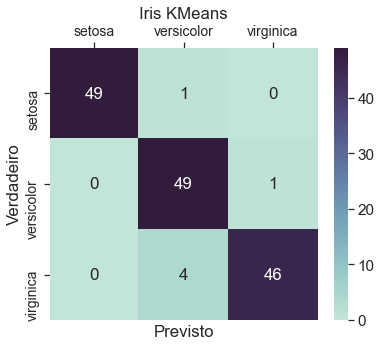

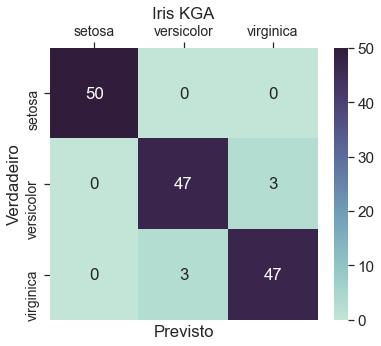

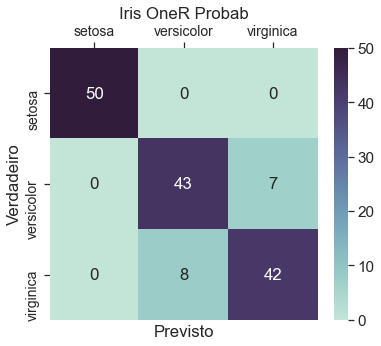

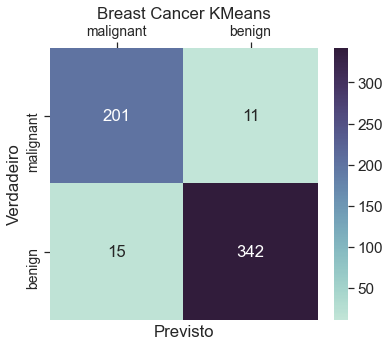

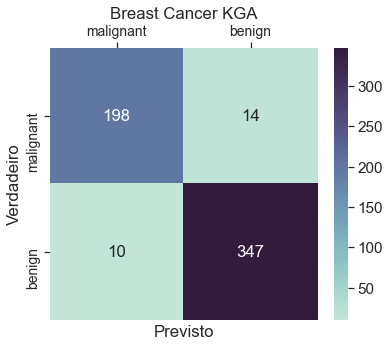

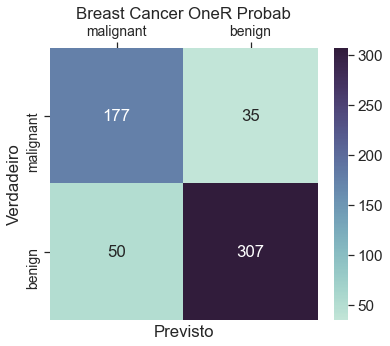

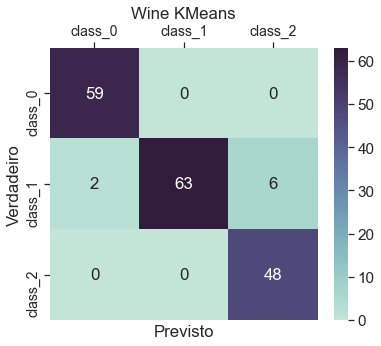

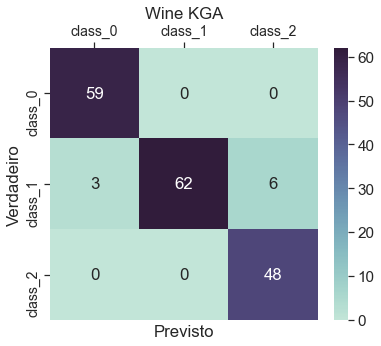

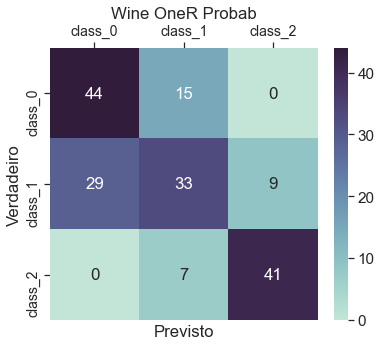

In [19]:
from sklearn.metrics import confusion_matrix

path = "plots/"
# Exibir e Salvar Matrizes de Confusão no diretorio definido acima
for ds_name in ["Iris", "Breast Cancer", "Wine"]:
    x, y = datasets_[ds_name].data, datasets_[ds_name].target
    labels = datasets_[ds_name].target_names

    for m in ["KMeans", "KGA", "OneR Probab"]:
        skf = StratifiedKFold(n_splits=10,random_state=rand_state, shuffle=True)

        classifier = classifs["call"][m]
        if hasattr(classifier, "k"):
            classifier.k = 7

        pipe_list = [('transformer', StandardScaler()), ('estimator', classifier)]
        if m == "OneR Probab": 
            discretizer = KBinsDiscretizer(2*len(np.unique(y)), encode='ordinal', strategy='kmeans')
            pipe_list.insert(1, ('discretizer', discretizer))
        pipeline = Pipeline(pipe_list)

        y_pred = cross_val_predict(pipeline, x, y, cv=skf)
        conf_mat = confusion_matrix(y, y_pred)

        plot_conf_mat(conf_mat, labels, ds_name + ' ' + m)

        filename = 'heatmap_'+ m + '_' + ds_name
        if m != "OneR Probab": filename += '_k7'

        # # Comente as duas linhas abaixo caso não deseje salvar no computador
        Path(path).mkdir(parents=True, exist_ok=True)
        plt.savefig(path + filename + '.png', dpi=200)

        plt.show()

## BOXPLOTS DOS SCORES

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

def plot_dataset_boxplot(dataset_df, dataset_name):
    # boxplot zscores and tempos
    figsize = (8, 5)
    _, ax = plt.subplots(figsize=figsize)
    ax.set(xlabel='Acurácia', ylabel='Classificador')

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    sns.boxplot(data=dataset_df.T, ax=ax, orient="h", palette="Set3")
    ax.set_title(dataset_name)
    # plt.yticks(rotation=20)
    plt.tight_layout()

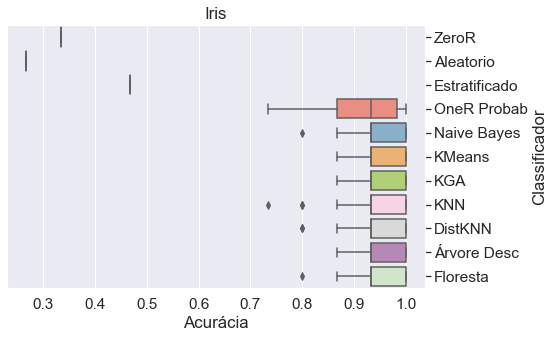

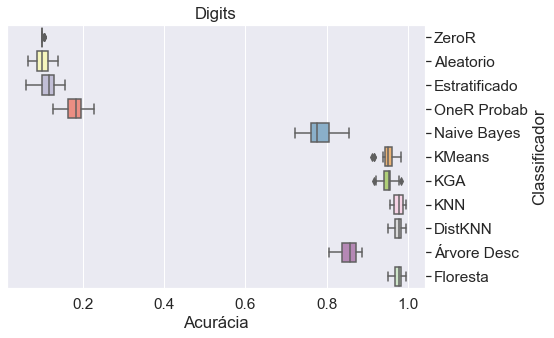

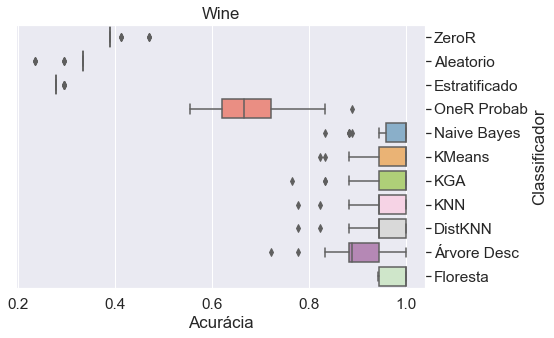

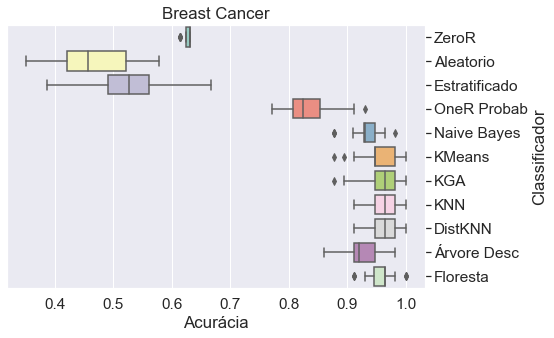

In [21]:
path = "plots/"
# Exibir e Salvar Matrizes de Confusão no diretorio definido acima
for ds_name, ds_data in results.items():
    score_df = pd.DataFrame({method: v["scores"] for method, v in ds_data.items()}).T
    plot_dataset_boxplot(score_df, ds_name)
        
    # Comente as duas linhas abaixo caso não deseje salvar no computador
    Path(path).mkdir(parents=True, exist_ok=True)
    plt.savefig(path + "boxplot_" + ds_name + '_scores',dpi=200)

    plt.show()


### EXIBIR/SALVAR TABELA DE TEMPOS

In [22]:
path = "tables/"

times = {}
for ds_name, ds_data in results.items():
    times[ds_name] = {method: v["time"] for method, v in ds_data.items()}

times_df = pd.DataFrame(times)

times_df.loc['Total por Dataset'] = times_df.sum()
times_df['Total por classif.'] = times_df.sum(axis=1)

display(times_df)

# Salvando a tabela de tempos na subpasta definida acima
Path(path).mkdir(parents=True, exist_ok=True)
with open(path+ "runtime_table.tex", 'w') as file:
    file.write(times_df.to_latex(float_format="%.2f", label="runtime_table"))
with open(path+ "[CSV]runtime_table.csv", 'w') as file:
    file.write(times_df.to_csv(float_format="%.2f"))

,Iris,Digits,Wine,Breast Cancer,Total por classif.
ZeroR,0.057224,0.095697,0.048716,0.057104,0.258741
Aleatorio,0.062580,0.096464,0.049114,0.055081,0.263239
Estratificado,0.063302,0.110851,0.056703,0.061483,0.292339
OneR Probab,1.435342,270.540988,4.226666,19.791560,295.994556
Naive Bayes,0.076750,0.155463,0.058919,0.067520,0.358652
KMeans,26.016338,130.504134,24.520848,38.648407,219.689727
KGA,61.671144,792.122441,69.587478,220.879328,1144.260391
KNN,1.635809,17.929737,1.700419,5.923024,27.188989
DistKNN,1.259005,9.647044,1.289180,3.061649,15.256878
Árvore Desc,1.116766,6.206889,1.239293,3.074011,11.636959


## TABELA T-TEST e WILCOXON

In [23]:
from scipy.stats import ttest_rel, wilcoxon

# Gerando tabela do teste t e wilcoxon de cada dataset
p_value_dfs = {}
for ds_name, ds_data in results.items():
    score_df = pd.DataFrame({method: v["scores"] for method, v in ds_data.items()}).T
    score_values = score_df.values
    p_value_df = np.full((len(score_values),len(score_values)), 1.)

    # Rodando ttest e wilcoxon
    for i, r1 in enumerate(score_values):
        for j, r2 in enumerate(score_values):
            if (r1==r2).all(): continue
            p_value_df[i,j] = ttest_rel(r1, r2)[1] if j > i else wilcoxon(r1, r2)[1] 

    p_value_dfs[ds_name] = pd.DataFrame(p_value_df, columns=score_df.index, index=score_df.index)
    display(ds_name, p_value_dfs[ds_name])

# torna negrito resultados rejeitados (menores ou iguais que 0.05)
def bold_formatter(x):
    return "\\textbf{%.5f}" % x if x <= 0.05 else '%.5f' % x


# Exportando tabelas como CSV e Latex
path = "tables/"
for ds_name, ds_p_value in p_value_dfs.items():
    name = ds_name.replace(" ", "_")
    column_names = [x[:5] for x in ds_p_value.columns]

    # Aplicar o formatador para todas as colunas
    formatters = [bold_formatter]*len(ds_p_value.columns)

    # Salvar tabela latex e CSV no subdiretorio /tables
    Path(path).mkdir(parents=True, exist_ok=True)
    with open(path + name + '_p_value_table.tex', 'w') as file:
        file.write(ds_p_value.to_latex(formatters=formatters, 
                                        escape=False, 
                                        index=False, 
                                        header=column_names, 
                                        label=name+"teste_pareado_table",
                                        caption= ds_name + ": p-values dos Testes Pareados. Teste t de Student na matrix triangular superior e Teste de Wilcoxon na matriz triangular inferior. Valores arredondados para cinco casas decimais."))

    with open(path + '[CSV]' + name + '_p_value_table.csv', 'w') as file:
        file.write(ds_p_value.to_csv(float_format="%.2e", header=column_names, index=column_names))

/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


'Iris'

,ZeroR,Aleatorio,Estratificado,OneR Probab,Naive Bayes,KMeans,KGA,KNN,DistKNN,Árvore Desc,Floresta
ZeroR,1.000000e+00,0.000000e+00,0.000000e+00,3.625163e-27,6.614062e-33,2.738657e-35,2.112177e-36,8.249202e-29,2.719388e-31,1.713313e-34,4.875186e-33
Aleatorio,4.320463e-08,1.000000e+00,0.000000e+00,1.583305e-28,3.448103e-34,1.434095e-36,1.103849e-37,4.197135e-30,1.396479e-32,8.896405e-36,2.514993e-34
Estratificado,4.320463e-08,4.320463e-08,1.000000e+00,6.401365e-24,7.182907e-30,2.946410e-32,2.287596e-33,9.505487e-26,3.072252e-28,1.885818e-31,5.454510e-30
OneR Probab,1.428061e-06,1.428061e-06,1.428061e-06,1.000000e+00,2.215122e-03,5.358247e-03,5.358247e-03,4.091007e-02,8.770799e-03,3.682943e-03,1.425827e-03
Naive Bayes,1.074534e-06,1.074534e-06,1.074534e-06,3.535644e-03,1.000000e+00,8.453803e-01,8.453803e-01,4.234951e-01,6.014763e-01,1.000000e+00,7.450142e-01
KMeans,9.911799e-07,9.911799e-07,9.911799e-07,7.914297e-03,8.684345e-01,1.000000e+00,1.000000e+00,2.826613e-01,4.479307e-01,7.867585e-01,6.014763e-01
KGA,8.702572e-07,8.702572e-07,8.702572e-07,8.006085e-03,8.684345e-01,1.000000e+00,1.000000e+00,3.444851e-01,5.218930e-01,8.011795e-01,6.452575e-01
KNN,1.155139e-06,1.155139e-06,1.155139e-06,4.387659e-02,4.754993e-01,3.049370e-01,3.567831e-01,1.000000e+00,3.255820e-01,3.800729e-01,4.146162e-01
DistKNN,1.132043e-06,1.132043e-06,1.132043e-06,1.093816e-02,5.929801e-01,4.385780e-01,4.987087e-01,2.568393e-01,1.000000e+00,6.014763e-01,7.122294e-01
Árvore Desc,1.060728e-06,1.060728e-06,1.060728e-06,4.605020e-03,1.000000e+00,7.815113e-01,7.962534e-01,4.385780e-01,5.929801e-01,1.000000e+00,7.450142e-01


'Digits'

,ZeroR,Aleatorio,Estratificado,OneR Probab,Naive Bayes,KMeans,KGA,KNN,DistKNN,Árvore Desc,Floresta
ZeroR,1.000000,0.914625,0.004093,2.766769e-17,4.230985e-41,3.380896e-51,2.735268e-52,2.320361e-56,1.878067e-57,7.959502e-46,3.290916e-56
Aleatorio,0.820129,1.000000,0.024473,3.471476e-13,1.312866e-38,2.668333e-46,7.173971e-46,9.245182e-47,3.698862e-47,7.771053e-43,1.476855e-47
Estratificado,0.008794,0.019757,1.000000,2.391892e-11,4.234274e-38,6.877142e-44,5.959741e-44,2.809039e-45,3.183051e-45,1.442504e-41,1.978643e-44
OneR Probab,0.000002,0.000002,0.000002,1.000000e+00,1.057525e-38,3.797118e-43,7.725434e-44,1.526314e-45,2.660885e-45,1.593857e-42,2.502374e-45
Naive Bayes,0.000002,0.000002,0.000002,1.722428e-06,1.000000e+00,2.329137e-23,1.801543e-23,1.728921e-24,2.148657e-25,9.637328e-12,2.115860e-25
KMeans,0.000002,0.000002,0.000002,1.724599e-06,1.722428e-06,1.000000e+00,8.171055e-01,9.542414e-10,4.111765e-10,5.047237e-20,4.425107e-09
KGA,0.000002,0.000002,0.000002,1.723514e-06,1.723514e-06,8.862415e-01,1.000000e+00,2.489767e-12,2.635175e-12,1.208262e-18,1.099263e-10
KNN,0.000002,0.000002,0.000002,1.719176e-06,1.723514e-06,3.735190e-06,1.706218e-06,1.000000e+00,4.042041e-01,1.325835e-21,7.980635e-01
DistKNN,0.000002,0.000002,0.000002,1.707294e-06,1.727860e-06,3.143795e-06,2.508343e-06,7.235078e-01,1.000000e+00,1.620758e-21,9.128560e-01
Árvore Desc,0.000002,0.000002,0.000002,1.724599e-06,3.146372e-06,1.714847e-06,1.727860e-06,1.724599e-06,1.720259e-06,1.000000e+00,5.702517e-21


/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


'Wine'

,ZeroR,Aleatorio,Estratificado,OneR Probab,Naive Bayes,KMeans,KGA,KNN,DistKNN,Árvore Desc,Floresta
ZeroR,1.000000e+00,1.335034e-08,1.950853e-24,1.154186e-17,1.142515e-29,2.950624e-29,2.032545e-27,6.097800e-29,4.334141e-29,4.972284e-27,1.713622e-35
Aleatorio,3.330222e-07,1.000000e+00,3.655820e-06,1.796824e-20,5.796583e-35,4.677767e-34,2.255680e-32,1.073429e-31,1.024542e-31,8.854698e-27,2.535193e-38
Estratificado,3.330222e-07,3.494174e-03,1.000000e+00,2.548493e-22,1.682651e-34,8.259922e-34,5.716655e-32,4.774825e-33,3.301192e-33,5.615764e-30,1.255944e-42
OneR Probab,1.603413e-06,1.607506e-06,1.606482e-06,1.000000e+00,1.500601e-17,7.320250e-17,2.252694e-16,5.379570e-17,3.113267e-17,3.184987e-13,1.202078e-18
Naive Bayes,8.056983e-07,8.056983e-07,8.022654e-07,1.630169e-06,1.000000e+00,1.577275e-01,9.025346e-02,3.169284e-03,1.672259e-03,6.181609e-08,1.611437e-01
KMeans,1.136631e-06,1.138931e-06,1.136631e-06,1.636397e-06,1.316680e-01,1.000000e+00,3.672487e-01,3.366939e-02,1.977592e-02,8.274765e-06,3.692900e-02
KGA,1.266544e-06,1.266544e-06,1.264868e-06,1.637436e-06,1.637060e-01,3.572726e-01,1.000000e+00,3.383835e-01,2.420771e-01,2.646921e-04,1.308702e-02
KNN,1.333405e-06,1.330780e-06,1.331654e-06,1.641601e-06,1.569476e-02,1.724434e-01,6.893025e-01,1.000000e+00,3.255820e-01,1.846193e-05,1.719120e-03
DistKNN,1.297045e-06,1.294480e-06,1.295334e-06,1.638477e-06,1.028591e-02,1.232646e-01,5.551339e-01,3.173105e-01,1.000000e+00,6.000890e-05,9.760144e-04
Árvore Desc,1.563968e-06,1.563968e-06,1.557972e-06,2.481339e-06,3.247680e-05,2.553844e-04,1.625152e-03,4.230854e-04,6.821297e-04,1.000000e+00,4.863720e-08


'Breast Cancer'

,ZeroR,Aleatorio,Estratificado,OneR Probab,Naive Bayes,KMeans,KGA,KNN,DistKNN,Árvore Desc,Floresta
ZeroR,1.000000,2.897445e-14,4.279828e-10,2.986870e-23,1.354275e-31,9.508690e-32,5.472188e-31,9.411920e-34,9.411920e-34,8.463425e-29,2.926097e-33
Aleatorio,0.000002,1.000000e+00,1.049650e-03,2.642294e-21,6.029275e-26,1.352926e-26,8.879116e-26,2.103982e-26,2.103982e-26,1.694022e-24,2.210177e-27
Estratificado,0.000002,2.412918e-03,1.000000e+00,5.540899e-23,6.805177e-25,7.910905e-24,5.304176e-24,6.060442e-25,6.060442e-25,2.200120e-23,1.596583e-24
OneR Probab,0.000002,1.690135e-06,1.696553e-06,1.000000e+00,2.807257e-13,1.082063e-13,5.709270e-14,1.027053e-15,1.027053e-15,1.708818e-10,1.254976e-14
Naive Bayes,0.000002,1.718093e-06,1.699769e-06,1.702991e-06,1.000000e+00,2.627581e-03,1.243910e-04,7.231289e-07,7.231289e-07,1.298494e-01,1.344812e-05
KMeans,0.000002,1.699769e-06,1.712687e-06,1.980170e-06,6.056518e-03,1.000000e+00,3.150094e-01,3.130731e-02,3.130731e-02,1.347640e-05,2.475792e-01
KGA,0.000002,1.713767e-06,1.713767e-06,1.712687e-06,4.404922e-04,2.360073e-01,1.000000e+00,1.836355e-01,1.836355e-01,2.975086e-05,8.938071e-01
KNN,0.000002,1.699769e-06,1.710528e-06,2.366017e-06,3.226302e-05,4.562885e-02,2.154483e-01,1.000000e+00,1.000000e+00,3.043835e-08,6.275985e-02
DistKNN,0.000002,1.699769e-06,1.710528e-06,2.366017e-06,3.226302e-05,4.562885e-02,2.154483e-01,1.000000e+00,1.000000e+00,3.043835e-08,6.275985e-02
Árvore Desc,0.000002,1.701916e-06,1.698696e-06,2.792831e-06,1.643195e-01,1.711207e-04,1.022819e-04,7.554808e-06,7.554808e-06,1.000000e+00,1.745165e-07
